In [1]:
!pip install cython
!pip install madmom
!pip install seaborn
import torchaudio
import torch
import ipywidgets as widgets
from IPython.display import display, Audio
import madmom
import matplotlib.pyplot as plt

In [16]:

fps = 100
print(fps)

# Your audio file path
file_path = "./../processed_dataset/Suryodaya/suryodaya_1_20bars/suryodaya_1_full_instrumental.wav"

proc = madmom.features.downbeats.DBNDownBeatTrackingProcessor(beats_per_bar=[4], fps=fps, correct=True)
act = madmom.features.downbeats.RNNDownBeatProcessor()(file_path)

downbeats = proc(act)

filtered_downbeats = downbeats[downbeats[:, 1] == 1, 0]
print("Filtered Downbeat Times:", filtered_downbeats)

100
Filtered Downbeat Times: [ 2.2   4.3   6.37  8.45 10.54 12.65 14.72 16.8  18.89 20.99 23.06 25.15
 27.24 29.35 31.41 33.5  35.59 37.69 39.76 41.84 43.96]


C:\Users\Ripple\AppData\Local\Programs\Python\Python39\lib\site-packages\madmom\features\downbeats.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best = np.argmax(np.asarray(results)[:, 1])


In [12]:
import madmom

# Assume the audio_np is already loaded and mono

# First, calculate the beat activation function
beat_act = madmom.features.beats.RNNBeatProcessor()(file_path)

# Then, use the DBNBeatTrackingProcessor for tracking the beats
beat_proc = madmom.features.beats.BeatDetectionProcessor(fps=100)
beats = beat_proc(beat_act)

print(beats)


[ 0.12  0.63  1.16  1.68  2.2   2.72  3.25  3.77  4.3   4.82  5.34  5.86
  6.38  6.9   7.42  7.94  8.46  8.98  9.5  10.03 10.55 11.07 11.59 12.11
 12.64 13.16 13.68 14.2  14.72 15.25 15.77 16.29 16.81 17.33 17.85 18.37
 18.89 19.42 19.94 20.46 20.99 21.51 22.03 22.55 23.07 23.59 24.11 24.63
 25.15 25.68 26.2  26.72 27.24 27.77 28.29 28.81 29.34 29.86 30.38 30.9
 31.42 31.94 32.46 32.98 33.5  34.03 34.55 35.07 35.59 36.11 36.64 37.16
 37.69 38.21 38.73 39.25 39.77 40.29 40.81 41.33 41.85 42.37 42.89 43.42
 43.95 44.48 45.   45.53]


3444


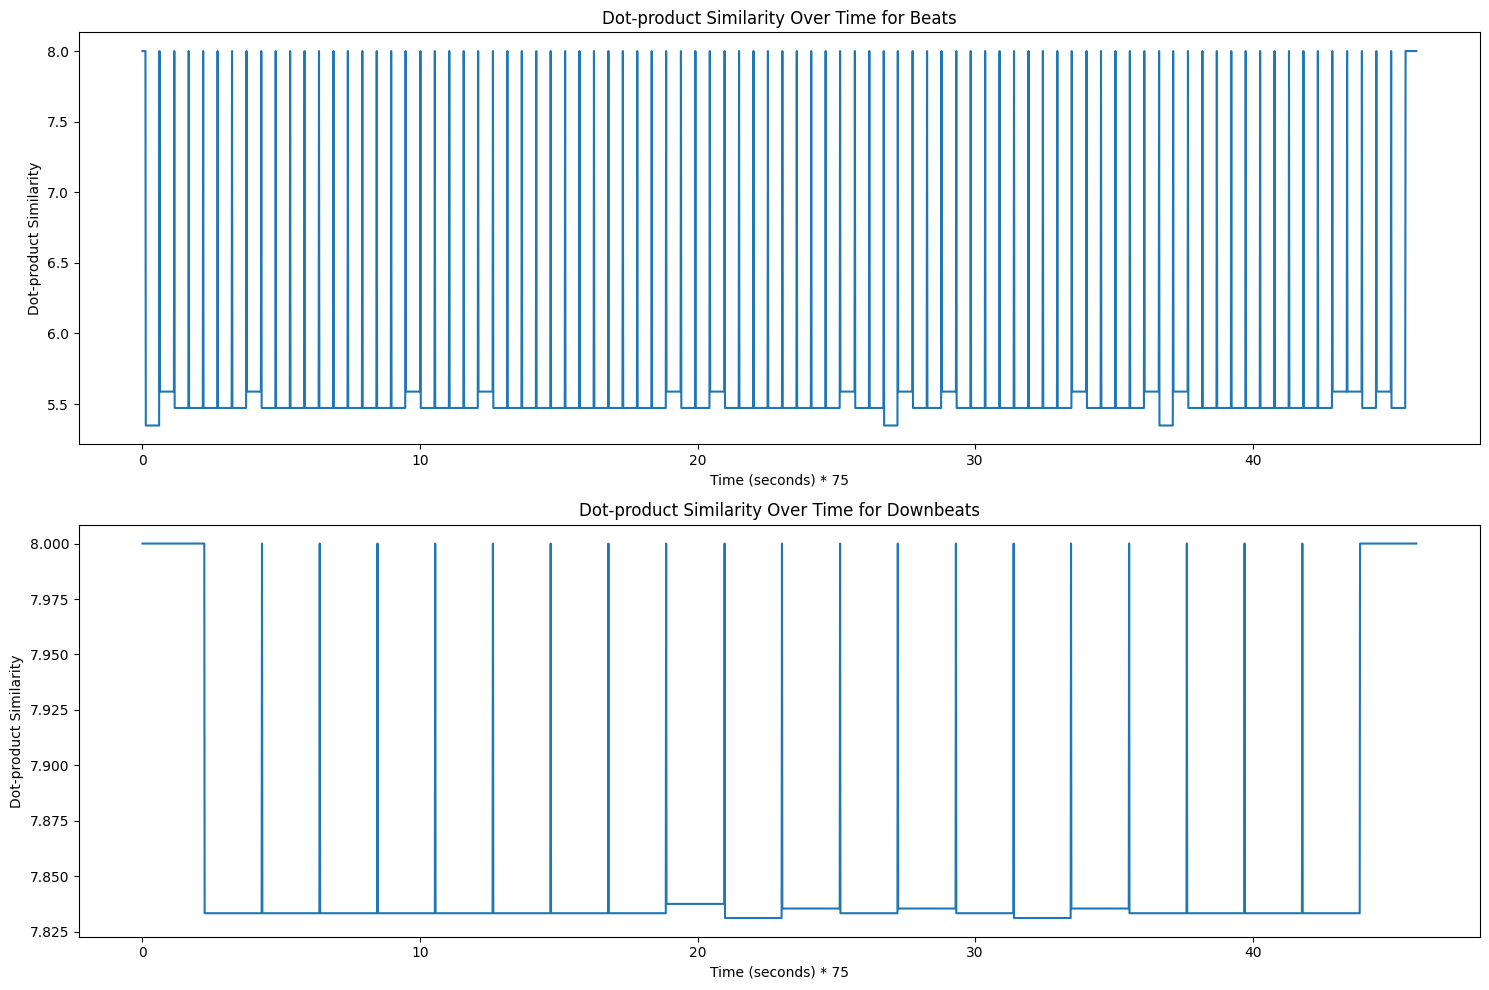

(3444, 32)


In [14]:
import numpy as np
# Example parameters
audio_duration = 45.91  # duration in seconds
fps = 75  # frames per second
total_frames = int(np.ceil(audio_duration * fps))  # total number of frames
print(total_frames)
# Simulated beat and downbeat times in seconds
beat_times = beats
downbeat_times = filtered_downbeats
# Create empty vectors

time_vector = np.linspace(0, audio_duration, total_frames)
beat_vector = np.zeros(total_frames)
downbeat_vector = np.zeros(total_frames)

# Function to create ramps in the vectors
def create_ramps(vector, times):
    indices = (times * fps).astype(int)
    for start, end in zip(indices[:-1], indices[1:]):
        vector[start:end] = np.linspace(0, 1, end - start)
    return vector

# Populate the vectors
beat_vector = create_ramps(beat_vector, beat_times)
downbeat_vector = create_ramps(downbeat_vector, downbeat_times)

# Sinusoidal transformation using the beat and downbeat vectors
k_values = np.arange(1, 9)
sin_features_beats = np.sin(2 * np.pi * np.outer(beat_vector, k_values))
cos_features_beats = np.cos(2 * np.pi * np.outer(beat_vector, k_values))
sin_features_downbeats = np.sin(2 * np.pi * np.outer(downbeat_vector, k_values))
cos_features_downbeats = np.cos(2 * np.pi * np.outer(downbeat_vector, k_values))

# Combine the sinusoidal features for beats and downbeats
combined_features_beats = np.concatenate((sin_features_beats, cos_features_beats), axis=1)
combined_features_downbeats = np.concatenate((sin_features_downbeats, cos_features_downbeats), axis=1)

# Compute the dot-product similarities for beats and downbeats
dot_product_similarity_beats = np.einsum('ij,ij->i', combined_features_beats[:-1], combined_features_beats[1:])
dot_product_similarity_downbeats = np.einsum('ij,ij->i', combined_features_downbeats[:-1], combined_features_downbeats[1:])

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Dot-product similarity for beats
axs[0].plot(time_vector[:-1], dot_product_similarity_beats)
axs[0].set_title('Dot-product Similarity Over Time for Beats')
axs[0].set_xlabel('Time (seconds) * 75')
axs[0].set_ylabel('Dot-product Similarity')

# Dot-product similarity for downbeats
axs[1].plot(time_vector[:-1], dot_product_similarity_downbeats)
axs[1].set_title('Dot-product Similarity Over Time for Downbeats')
axs[1].set_xlabel('Time (seconds) * 75')
axs[1].set_ylabel('Dot-product Similarity')

plt.tight_layout()
plt.show()

positional_embedding = np.concatenate((combined_features_beats, combined_features_downbeats), axis = 1)
print(positional_embedding.shape)

24000


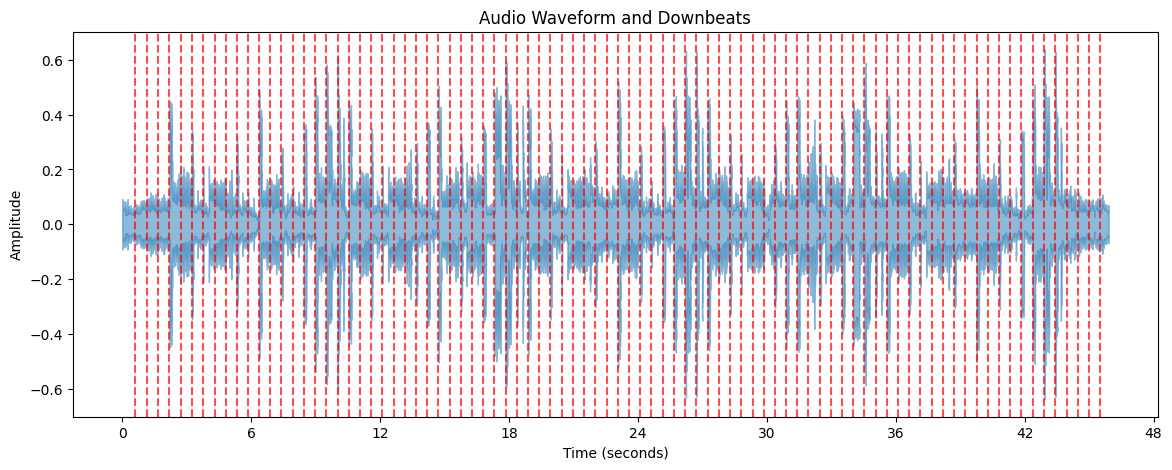

In [47]:
!pip install matplotlib librosa numpy

import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# Load your audio file
y, sr = librosa.load(file_path, sr=None)  # Load with the original sampling rate
print(sr)
# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Audio Waveform and Downbeats')

# Assuming `downbeats` is a numpy array from your downbeat detection
# Example: downbeats = np.array([[0.08, 1], [0.65, 2], ..., [49.56, 4]])

# Extract downbeat times and possibly bar markers if needed
downbeat_times = downbeats[:, 0]

# Add vertical lines for each downbeat
for db_time in downbeat_times:
    plt.axvline(x=db_time, color='r', linestyle='--', alpha=0.7)  # Red dashed line for downbeats

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


In [63]:
print(downbeats.shape)

(43, 2)


(47, 16, 150)


In [38]:
# Access the first sequence's first channel's 150 codes
first_sequence_first_channel = pos[0, 0, :]

# Access the second sequence's first channel's 150 codes
second_sequence_first_channel = pos[3, 0, :]

print("First Sequence, First Channel, 150 Codes:")
print(first_sequence_first_channel)

print("\nSecond Sequence, First Channel, 150 Codes:")
print(second_sequence_first_channel)

First Sequence, First Channel, 150 Codes:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

Second Sequence, First Channel, 150 Codes:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.